In [55]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
file_to_read = "../Resources/AviationData_Weather.csv"

data_df = pd.read_csv(file_to_read, encoding='ISO-8859-1', low_memory=False)



data_df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
0,20001218X45444,Accident,SEA87LA080,1948-10-24,"MOOSE CREEK, ID",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,UNK,Cruise,Probable Cause,NaN
1,20001218X45447,Accident,LAX94LA336,1962-07-19,"BRIDGEPORT, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,4.0,0.0,0.0,0.0,UNK,Unknown,Probable Cause,19-09-1996
2,20061025X01555,Accident,NYC07LA005,1974-08-30,"Saltville, VA",United States,36.922223,-81.878056,NaN,NaN,...,Personal,NaN,3.0,NaN,NaN,NaN,IMC,Cruise,Probable Cause,26-02-2007
3,20001218X45448,Accident,LAX96LA321,1977-06-19,"EUREKA, CA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,2.0,0.0,0.0,0.0,IMC,Cruise,Probable Cause,12-09-2000
4,20041105X01764,Accident,CHI79FA064,1979-08-02,"Canton, OH",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,1.0,2.0,NaN,0.0,VMC,Approach,Probable Cause,16-04-1980


# Preproccessing

In [57]:

data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87282 entries, 0 to 87281
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                87282 non-null  object 
 1   Investigation.Type      87282 non-null  object 
 2   Accident.Number         87282 non-null  object 
 3   Event.Date              87282 non-null  object 
 4   Location                87230 non-null  object 
 5   Country                 87056 non-null  object 
 6   Latitude                33073 non-null  object 
 7   Longitude               33064 non-null  object 
 8   Airport.Code            49322 non-null  object 
 9   Airport.Name            51955 non-null  object 
 10  Injury.Severity         86399 non-null  object 
 11  Aircraft.damage         84272 non-null  object 
 12  Aircraft.Category       30783 non-null  object 
 13  Registration.Number     85965 non-null  object 
 14  Make                    87219 non-null

In [58]:
data_df.describe()

,Number.of.Engines,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured
count,81533.000000,75881.000000,74772.000000,75349.000000,81370.000000
mean,1.147131,0.652772,0.280921,0.360814,5.311847
std,0.447085,5.521338,1.557476,2.257721,27.899156
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,0.000000,0.000000,1.000000
75%,1.000000,0.000000,0.000000,0.000000,2.000000
max,8.000000,349.000000,161.000000,380.000000,699.000000


In [59]:
data_df.shape

(87282, 31)

In [60]:
# Keep rows where Investigation.Type = Accident, Country= United States, and Aircraft.Category= Airplane

filtered_df = data_df.loc[(data_df['Aircraft.Category']=='Airplane') & (data_df['Country']== 'United States') & (data_df['Investigation.Type'] == 'Accident')]
filtered_df.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Purpose.of.flight,Air.carrier,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Broad.phase.of.flight,Report.Status,Publication.Date
5,20170710X52551,Accident,NYC79AA106,1979-09-17,"BOSTON, MA",United States,42.445277,-70.758333,NaN,NaN,...,NaN,Air Canada,NaN,NaN,1.0,44.0,VMC,Climb,Probable Cause,19-09-2017
7,20020909X01562,Accident,SEA82DA022,1982-01-01,"PULLMAN, WA",United States,NaN,NaN,NaN,BLACKBURN AG STRIP,...,Personal,NaN,0.0,0.0,0.0,2.0,VMC,Takeoff,Probable Cause,01-01-1982
8,20020909X01561,Accident,NYC82DA015,1982-01-01,"EAST HANOVER, NJ",United States,NaN,NaN,N58,HANOVER,...,Business,NaN,0.0,0.0,0.0,2.0,IMC,Landing,Probable Cause,01-01-1982
12,20020917X02148,Accident,FTW82FRJ07,1982-01-02,"HOMER, LA",United States,NaN,NaN,NaN,NaN,...,Personal,NaN,0.0,0.0,1.0,0.0,IMC,Cruise,Probable Cause,02-01-1983
13,20020917X02134,Accident,FTW82FRA14,1982-01-02,"HEARNE, TX",United States,NaN,NaN,T72,HEARNE MUNICIPAL,...,Personal,NaN,1.0,0.0,0.0,0.0,IMC,Takeoff,Probable Cause,02-01-1983


In [61]:
# percent of missing data per column
pct_missing = filtered_df.isnull().mean()

pct_missing_df = pd.DataFrame(pct_missing, columns=['Missing'])
pct_missing_df.sort_values('Missing', ascending = False, inplace = True)

# columns with more than 10% missing values
print(pct_missing_df[pct_missing_df['Missing'] > 0.1])

                         Missing
Schedule                0.933713
Broad.phase.of.flight   0.725314
Air.carrier             0.606474
Airport.Code            0.302288
Airport.Name            0.279456
Longitude               0.143835
Latitude                0.143393
Total.Fatal.Injuries    0.128643
Total.Serious.Injuries  0.127760
Total.Minor.Injuries    0.112568


In [62]:
# Drop columns with 35% missing values or more
dfb = filtered_df.copy()
cols_to_drop = list(pct_missing_df[pct_missing_df['Missing'] > 0.35].index)
dfb.drop(columns = cols_to_drop, axis =1, inplace = True, errors = 'coerce')
print(cols_to_drop)

['Schedule', 'Broad.phase.of.flight', 'Air.carrier']


In [63]:
# Check for duplicate rows
print(dfb.duplicated().sum())

0


In [64]:
# Change dates to datetime remove Cardinal point abb. from lat and lon

dfb.loc[:,'Event.Date'] = pd.to_datetime(dfb['Event.Date'])
dfb.loc[:,'Publication.Date'] = pd.to_datetime(dfb['Publication.Date'])
dfb.loc[:, 'Latitude'] = dfb['Latitude'].str.replace('N|S', '', regex = True)
dfb.loc[:,'Latitude'] = pd.to_numeric(dfb['Latitude'], downcast='float')
dfb.loc[:,'Longitude'] = dfb['Longitude'].str.replace('W|E','', regex= True)
dfb.loc[:,'Longitude'] = pd.to_numeric(dfb['Longitude'], downcast='float')



In [65]:
dfb.sample(10)

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Engine.Type,FAR.Description,Purpose.of.flight,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Report.Status,Publication.Date
76427,20150504X31324,Accident,CEN15LA215,2015-03-24,"Circleville, TX",United States,303423.000000,9.725110e+05,NaN,NaN,...,Reciprocating,091,Instructional,0.0,0.0,0.0,2.0,VMC,The failure of the engine to regain normal pow...,2020-09-25
62478,20070617X00753,Accident,SEA07CA123,2007-05-06,"SAN JOSE, CA",United States,37.330002,-1.216864e+02,RHV,REID-HILLVIEW OF SANTA CLARA C,...,Reciprocating,Part 91: General Aviation,Personal,NaN,NaN,NaN,2.0,VMC,Probable Cause,2007-07-25
80770,20171016X74852,Accident,ANC18LA004,2017-10-15,"Tuskegee, AL",United States,322738.000000,8.540480e+05,06A,Moton Field Muncipal Airport,...,Reciprocating,091,Personal,0.0,0.0,0.0,3.0,VMC,An improperly adjusted slope controller and fu...,2020-09-25
71607,20120417X00541,Accident,ERA12LA287,2012-04-13,"Cross Keys, NJ",United States,401757.000000,7.431140e+05,17N,Cross Keys Airport,...,Reciprocating,091,Personal,0.0,0.0,0.0,1.0,VMC,The pilot's failure to maintain control of the...,2020-09-25
80290,20170811X11157,Accident,CEN17LA313,2017-07-20,"Grady, AR",United States,34448.000000,9.142300e+04,NaN,NaN,...,Reciprocating,091,Personal,0.0,0.0,0.0,1.0,VMC,The loss of engine power due to a lack of igni...,2020-09-25
79125,20161016X51930,Accident,ERA17LA015,2016-10-16,"Stockbridge, GA",United States,333159.000000,8.410190e+05,7GA7,BERRY HILL,...,Reciprocating,091,Personal,0.0,0.0,2.0,0.0,VMC,A partial loss of engine power due to a stuck ...,2020-09-25
81025,20171215X12327,Accident,CEN18LA052,2017-12-25,"Riverton, WY",United States,43351.000000,1.082735e+06,RIW,Riverton Regional,...,Reciprocating,091,Personal,0.0,0.0,0.0,5.0,VMC,The pilot's loss of directional control during...,2020-09-25
77839,20160202X64511,Accident,CEN16LA097,2016-02-01,"Sturtevant, WI",United States,424213.000000,8.757140e+05,C89,SYLVANIA,...,Reciprocating,091,Personal,0.0,0.0,0.0,2.0,VMC,The pilot's failure to maintain a proper glide...,2020-09-25
1676,20020917X03704,Accident,LAX82FUM07,1982-06-22,"IMPERIAL, CA",United States,NaN,NaN,NaN,FORRESTER & NORTHINGTON,...,Reciprocating,Part 137: Agricultural,Unknown,0.0,0.0,0.0,1.0,VMC,Probable Cause,1983-06-22
1993,20020917X02883,Accident,ATL82FLJ07,1982-07-17,"GATESVILLE, NC",United States,NaN,NaN,NaN,NaN,...,Reciprocating,Part 91: General Aviation,Personal,0.0,2.0,0.0,0.0,VMC,Probable Cause,1983-07-17


In [66]:
# Add year, month, and day columns and limit our DF to year 2000 and after
dfb['Year'] = dfb['Event.Date'].dt.year
dfb['Month'] = dfb['Event.Date'].dt.month
dfb['Day_of_Week'] = dfb['Event.Date'].dt.weekday
dfb = dfb[dfb['Year'] >= 2000]

def day_of_week_to_string(day_of_week):
    if day_of_week == 0:
        return 'Monday'
    elif day_of_week == 1:
        return 'Tuesday'
    elif day_of_week == 2:
        return 'Wednesday'
    elif day_of_week == 3:
        return 'Thursday'
    elif day_of_week == 4:
        return 'Friday'
    elif day_of_week == 5:
        return 'Saturday'
    elif day_of_week == 6:
        return 'Sunday'

dfb['Day_of_Week'] = dfb['Day_of_Week'].apply(day_of_week_to_string)
dfb.head()

,Event.Id,Investigation.Type,Accident.Number,Event.Date,Location,Country,Latitude,Longitude,Airport.Code,Airport.Name,...,Total.Fatal.Injuries,Total.Serious.Injuries,Total.Minor.Injuries,Total.Uninjured,Weather.Condition,Report.Status,Publication.Date,Year,Month,Day_of_Week
47743,20001212X20393,Accident,LAX00LA078,2000-01-21,"COMPTON, CA",United States,NaN,NaN,CPM,COMPTON,...,NaN,NaN,1.0,NaN,VMC,Probable Cause,2015-08-16,2000,1,Friday
47864,20001212X20487,Accident,FTW00FA083B,2000-02-16,"MCALESTER, OK",United States,NaN,NaN,MLC,MCALESTER REGIONAL,...,1.0,NaN,NaN,1.0,VMC,Probable Cause,2010-01-28,2000,2,Wednesday
47869,20001212X20487,Accident,FTW00FA083A,2000-02-16,"MCALESTER, OK",United States,NaN,NaN,MLC,MCALESTER REGIONAL,...,1.0,NaN,NaN,1.0,VMC,Probable Cause,2010-01-28,2000,2,Wednesday
47870,20001212X20472,Accident,DCA00MA026,2000-02-16,"RANCHO CORDOVA, CA",United States,NaN,NaN,MHR,Sacramento Mather Airport,...,3.0,NaN,NaN,NaN,VMC,Probable Cause,2009-09-29,2000,2,Wednesday
47876,20001212X20521,Accident,LAX00LA105,2000-02-18,"ELKO, NV",United States,40.816666,-115.791664,NaN,NaN,...,NaN,NaN,1.0,NaN,VMC,Probable Cause,2010-07-15,2000,2,Friday


In [67]:
dfb.dtypes

Event.Id                          object
Investigation.Type                object
Accident.Number                   object
Event.Date                datetime64[ns]
Location                          object
Country                           object
Latitude                         float32
Longitude                        float32
Airport.Code                      object
Airport.Name                      object
Injury.Severity                   object
Aircraft.damage                   object
Aircraft.Category                 object
Registration.Number               object
Make                              object
Model                             object
Amateur.Built                     object
Number.of.Engines                float64
Engine.Type                       object
FAR.Description                   object
Purpose.of.flight                 object
Total.Fatal.Injuries             float64
Total.Serious.Injuries           float64
Total.Minor.Injuries             float64
Total.Uninjured 

In [68]:
# value counts
for col in dfb.columns:
    print(dfb[col].value_counts().nlargest(10))
    print('--------------------------\n')

20071108X01768    2
20010226X00510    2
20080213X00187    2
20061015X01521    2
20070426X00458    2
20050825X01313    2
20060601X00665    2
20070705X00879    2
20070111X00042    2
20051213X01965    2
Name: Event.Id, dtype: int64
--------------------------

Accident    19456
Name: Investigation.Type, dtype: int64
--------------------------

LAX00LA078    1
GAA16CA104    1
GAA16CA109    1
GAA16CA108    1
CEN16FA086    1
CEN16FA087    1
ERA16FA089    1
GAA16CA105    1
CEN16FA083    1
GAA16CA348    1
Name: Accident.Number, dtype: int64
--------------------------

2011-06-18    14
2010-05-29    14
2011-03-19    14
2011-07-23    14
2012-08-31    14
2012-07-21    13
2018-09-01    13
2008-08-02    12
2007-10-07    12
2011-08-13    12
Name: Event.Date, dtype: int64
--------------------------

Anchorage, AK      90
Talkeetna, AK      67
Phoenix, AZ        64
Palmer, AK         64
Fairbanks, AK      62
Atlanta, GA        53
Houston, TX        50
Reno, NV           50
Miami, FL          48
San Ant

In [69]:
# bucket private and none
dfb["Airport.Name"] = dfb["Airport.Name"].apply(lambda x: "Unknown" if pd.isnull(x) else "Private" if "private" in x.lower() else "NONE" if "none" in x.lower() or "pvt" in x.lower() else x)
dfb["Airport.Name"] = dfb["Airport.Name"].str.title()
dfb["Airport.Name"].value_counts()

Unknown                           5172
Private                            433
None                                86
Merrill Field                       30
Reno/Stead                          26
                                  ... 
Mallards Landing Airport             1
Palm Springs Internat'L Airpor       1
County Memorial Airport              1
Park Falls Municipal Airport         1
Ellinwood Muni                       1
Name: Airport.Name, Length: 7691, dtype: int64

In [70]:
for airport_name in dfb["Airport.Name"].unique():
  print(airport_name)

Compton
Mcalester Regional
Sacramento Mather Airport
Unknown
Burbank-Glendale-Pasadena
Marianna Muni
Winnemucca Muni
Wallace Municipal Airport
Willow Run Airport
General Edward Lawrence Logan
Southern Comforts Aerodrome
Troy Municipal
Nashville International Airpor
Logan International Airport
Pinedale
Platte Valley Airpark
Cook Airfield Inc
Boulder City Municipal
Sarasota International Airport
Bishop
Lakeland-Linder Regional
Vero Beach Municipal
Alta Sierra
Simsbury Airport
Wittman Regional
Headland Municipal Airport
Medina Municipal
None
Graham Municipal
Igor I. Sikorsky Airport
Northern Kentucky Intl
Double Eagle Ii
Iraan Municipal Airport
Indianapolis International
Animas Air Park
Thompson-Robbins
South Jersey Rgnl
Poe'S Airport
Dennis Cantrell Field
Renner Fld /Goodland Municipal
Kansas City International
Jacksonville Muni
Custer
Lowell City
Sparta Community Airport
West Texas
Scribner State
Mecosta
Schuy-Rush
Black Hills-Clyde Ice Field
Dodge County
Mattawn Airpark
Ingleside
Hendr

In [71]:
# "Anchorage, AK" Split 'Location' in City and State
dfb['Location'] = dfb['Location'].str.replace(',', ', ')
dfb[['City','State']] = dfb['Location'].str.split(', ', n=1, expand=True)
dfb[['City','State']]
dfb['City'] = dfb['City'].str.title()

In [72]:
# Combine same Makes 
dfb["Make"] = dfb["Make"].str.title()


In [73]:
for make in dfb['Make'].unique():
  print(make)

Myers
Cessna
Douglas
Ayres
Boeing
Learjet
Steel/Vans
Schweizer
Beech
Mcdonnell Douglas
Dassault-Breguet
Meshko Zenair
Piper
De Havilland
Henry
Bennett
Moravan
Taylorcraft
Schuchart
Edge
Thomson
Rans, Inc.
Swearingen
Ercoupe
Waco
Grenier
Gulfstream American
Aero Commander
Baughman
Grumman
Bilgri
Eckstein
Air Tractor
Giroux
Grumman American
Crawford
Bellanca
Tomash
Beechcraft
Ercoupe (Eng & Research Corp.)
Aviat
Mooney
Consolidated Aeronautics Inc.
Carlisle
Maule
Mathews
Larry Woods
Socata
Wsk Pzl Mielec
Ayers
Kolb Company
Stinson
Maysmike
Diamond Aircraft Industries
Aircraft Mfg & Dev. Co. (Amd)
Lancair
Kucklick
Fairchild
Unknown
Wells
Starduster
Williams
Lockheed
Price
Lake
American General Aircraft
Howard Aircraft Corp.
Velocity
Avions Max Holste
Cleveland Orson
William F. Lair
R. James Thorne
Globe
Clement-Kazmierczak
Luscombe
Fleet
American Champion (Acac)
Danbrook
Jerry Garrison
Menefee
Rockwell
Dantzer Lawrence L
Yakovlev
Aeronca
Andrews
Bolger Scott
Sawyer
Villeneuve
Fraker
Loehl

In [74]:
dfb['Make'].value_counts().nlargest(10)

Cessna                6002
Piper                 3381
Beech                 1182
Mooney                 314
Boeing                 288
Bellanca               209
Maule                  198
Air Tractor Inc        196
Aeronca                182
Cirrus Design Corp     170
Name: Make, dtype: int64

In [75]:
# combine registration labels
dfb['Registration.Number'] = dfb['Registration.Number'].apply(lambda x: "Unknown" if pd.isnull(x) else "NONE" if "none" in x.lower() else "UNREG" if "unreg" in x.lower() else x)

In [76]:
dfb['Registration.Number'].value_counts().nlargest(10)

UNREG     60
NONE      16
N8402K     5
N5408Y     4
N323KT     4
N99HV      4
N65645     3
N460CT     3
N185DK     3
N8376K     3
Name: Registration.Number, dtype: int64

In [77]:
for registration in dfb['Registration.Number'].unique():
  print(registration)

N813S
N9505B
N91994
N8079U
N4011Y
N668SW
N86BE
N522SW
N64ME
N3629D
N806BF
EI-CRL
N155DL
N5883B
N1DC
N17AE
N3735D
N802US
N59CF
N4386W
N2507X
N9277X
N7640P
N120BA
N696DH
N262MM
N241GS
N125PM
N8253W
N526GC
N5142D
N4418U
N325HP
N7202E
N63351
N4795D
N612UA
N39945
N3862D
N541TW
N325L
N1173R
N6134A
N7427J
N556UP
N87WW
N509R
N754NW
N4642J
N9454J
N5079J
N4090D
N94769
NC662Y
N140NJ
N1419
N3545R
N52WP
N7744B
N358RW
N7791V
N290KB
N6912S
N4866Q
N623U
N1373E
N9B
N747BS
N6321B
N2326S
N1029G
N81310
N3R
N7634Z
N8851V
N7300R
N369AF
N6688D
N9855S
N2601N
N3989H
N2870S
N6QR
N21689
N5337B
N5556Q
N3345Y
N847EX
N1302D
N5244D
N878A
N5066M
N4794P
N6193V
N402ME
N2585B
N9852J
N1122Y
N752CF
N628
N5629G
N944FE
N9973H
N132JH
N219ME
N366X
N613SP
N4413C
N405BM
N2535R
CGDJF
N757AZ
N705QD
N175W
N82204
N76494
N258P
N221SA
N1156N
N55175
N211EZ
N82946
NONE
N759XA
N4903F
N53352
N2279Y
N9298D
N8548S
N7342G
N555MR
N930TG
N4506L
N2825X
N4133Y
N7501H
N6216M
N540Q
N279WP
N70LB
N410GV
N787WW
N33WL
N83272
N25SF
N905CT
N299KP
N758L

In [78]:
# Change to 0 and 1 in case data is used for machine learning
dfb['Amateur.Built'] = dfb['Amateur.Built'].map({'Yes': 1, 'No': 0, 'Y': 1, 'N':0})
dfb['Amateur.Built'].value_counts()

0.0    16682
1.0     2772
Name: Amateur.Built, dtype: int64

In [79]:
# Combine injury values
dfb['Injury.Severity'] = dfb['Injury.Severity'].str.split('(').str[0]
dfb['Injury.Severity'].fillna('Unknown')

47743    Non-Fatal
47864        Fatal
47869        Fatal
47870        Fatal
47876    Non-Fatal
           ...    
87264    Non-Fatal
87265    Non-Fatal
87270    Non-Fatal
87271    Non-Fatal
87277        Fatal
Name: Injury.Severity, Length: 19456, dtype: object

In [80]:
dfb['Injury.Severity'].value_counts()

Non-Fatal    16407
Fatal         3018
Name: Injury.Severity, dtype: int64

In [81]:
# Check weather conditions column
dfb['Weather.Condition']
dfb['Weather.Condition'] = dfb['Weather.Condition'].replace({'Unk': 'UNK'})
dfb['Weather.Condition'].value_counts()

VMC    18178
IMC      910
UNK       82
Name: Weather.Condition, dtype: int64

In [82]:
# Add a seasons column
def assign_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3,4,5]:
        return 'Spring'
    elif month in [6,7,8]:
        return 'Summer'
    else:
        return 'Autum'
    
dfb['Season'] = dfb["Event.Date"].dt.month.apply(assign_season)

In [83]:
# Dropping columns and changing '.' to '_'
cols_to_drop = ['Event.Id', 'Accident.Number','Location','Total.Fatal.Injuries',
                'Total.Serious.Injuries', 'Total.Minor.Injuries', 'Total.Uninjured']

dfb = dfb.drop(columns = cols_to_drop)
    
dfb.columns = dfb.columns.str.replace('.', '_')

dfb.head()

C:\Users\wero\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  import sys


,Investigation_Type,Event_Date,Country,Latitude,Longitude,Airport_Code,Airport_Name,Injury_Severity,Aircraft_damage,Aircraft_Category,...,Purpose_of_flight,Weather_Condition,Report_Status,Publication_Date,Year,Month,Day_of_Week,City,State,Season
47743,Accident,2000-01-21,United States,NaN,NaN,CPM,Compton,Non-Fatal,Substantial,Airplane,...,Personal,VMC,Probable Cause,2015-08-16,2000,1,Friday,Compton,CA,Winter
47864,Accident,2000-02-16,United States,NaN,NaN,MLC,Mcalester Regional,Fatal,Substantial,Airplane,...,Unknown,VMC,Probable Cause,2010-01-28,2000,2,Wednesday,Mcalester,OK,Winter
47869,Accident,2000-02-16,United States,NaN,NaN,MLC,Mcalester Regional,Fatal,Destroyed,Airplane,...,Personal,VMC,Probable Cause,2010-01-28,2000,2,Wednesday,Mcalester,OK,Winter
47870,Accident,2000-02-16,United States,NaN,NaN,MHR,Sacramento Mather Airport,Fatal,Destroyed,Airplane,...,NaN,VMC,Probable Cause,2009-09-29,2000,2,Wednesday,Rancho Cordova,CA,Winter
47876,Accident,2000-02-18,United States,40.816666,-115.791664,NaN,Unknown,Non-Fatal,Substantial,Airplane,...,Positioning,VMC,Probable Cause,2010-07-15,2000,2,Friday,Elko,NV,Winter


In [84]:
dfb.columns

Index(['Investigation_Type', 'Event_Date', 'Country', 'Latitude', 'Longitude',
       'Airport_Code', 'Airport_Name', 'Injury_Severity', 'Aircraft_damage',
       'Aircraft_Category', 'Registration_Number', 'Make', 'Model',
       'Amateur_Built', 'Number_of_Engines', 'Engine_Type', 'FAR_Description',
       'Purpose_of_flight', 'Weather_Condition', 'Report_Status',
       'Publication_Date', 'Year', 'Month', 'Day_of_Week', 'City', 'State',
       'Season'],
      dtype='object')

In [85]:
rearrange_cols = ['Investigation_Type','Event_Date','Year','Month','Season', 'Day_of_Week','Country',
                  'State','Injury_Severity','Aircraft_damage','Airport_Name','Airport_Code',
                  'Aircraft_Category','Registration_Number','Make','Model', 'Amateur_Built',
                  'Number_of_Engines','Engine_Type','FAR_Description', 'Purpose_of_flight',
                  'Weather_Condition','Report_Status', 'Publication_Date']

clean_aviation_df = dfb[rearrange_cols]

clean_aviation_df.head()

,Investigation_Type,Event_Date,Year,Month,Season,Day_of_Week,Country,State,Injury_Severity,Aircraft_damage,...,Make,Model,Amateur_Built,Number_of_Engines,Engine_Type,FAR_Description,Purpose_of_flight,Weather_Condition,Report_Status,Publication_Date
47743,Accident,2000-01-21,2000,1,Winter,Friday,United States,CA,Non-Fatal,Substantial,...,Myers,Q-2,1.0,1.0,Reciprocating,Part 91: General Aviation,Personal,VMC,Probable Cause,2015-08-16
47864,Accident,2000-02-16,2000,2,Winter,Wednesday,United States,OK,Fatal,Substantial,...,Cessna,208B,0.0,1.0,Turbo Prop,Part 135: Air Taxi & Commuter,Unknown,VMC,Probable Cause,2010-01-28
47869,Accident,2000-02-16,2000,2,Winter,Wednesday,United States,OK,Fatal,Destroyed,...,Cessna,182M,0.0,1.0,Reciprocating,Part 91: General Aviation,Personal,VMC,Probable Cause,2010-01-28
47870,Accident,2000-02-16,2000,2,Winter,Wednesday,United States,CA,Fatal,Destroyed,...,Douglas,DC-8-71F,0.0,4.0,Turbo Fan,Part 121: Air Carrier,NaN,VMC,Probable Cause,2009-09-29
47876,Accident,2000-02-18,2000,2,Winter,Friday,United States,NV,Non-Fatal,Substantial,...,Ayres,NaN,0.0,1.0,NaN,Part 91: General Aviation,Positioning,VMC,Probable Cause,2010-07-15


# Analysis

* What types of weather conditions are most commonly associated with aviation accidents?

* How does the frequency of aviation accidents vary with different weather conditions?

* Are certain types of aircraft more prone to accidents in certain weather conditions?

* How does the severity of aviation accidents vary with different weather conditions?

* Are there certain geographical regions that are more prone to aviation accidents due to weather conditions?

* Can aviation accidents be prevented or mitigated by taking specific precautions in certain weather conditions?

* What role do human factors, such as pilot error or inadequate training, play in aviation accidents that are caused by adverse weather conditions?

Text(0.5, 1.0, 'Accidents per Season(US)')

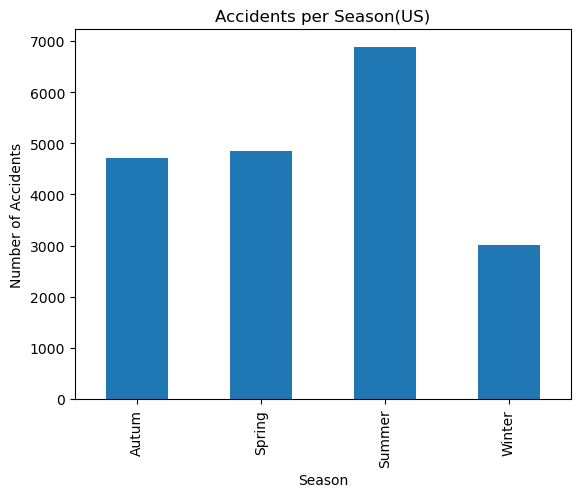

In [86]:
accidents_per_season = clean_aviation_df.groupby('Season')['Event_Date'].count()

accidents_per_season.plot(kind='bar')
plt.xlabel('Season')
plt.ylabel('Number of Accidents')
plt.title('Accidents per Season(US)')

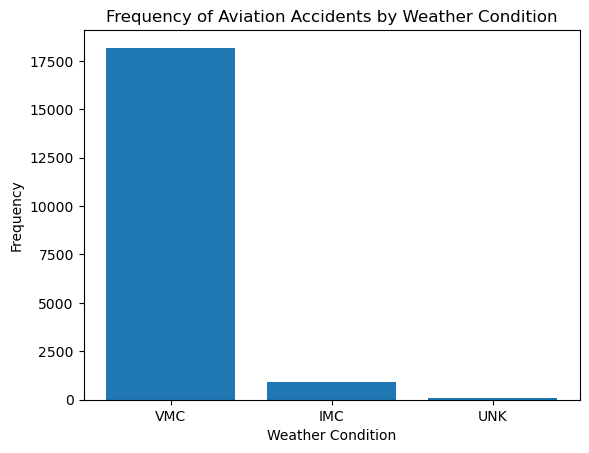

In [87]:
weather_counts = clean_aviation_df['Weather_Condition'].value_counts()

plt.bar(weather_counts.index, weather_counts.values)
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.title('Frequency of Aviation Accidents by Weather Condition')
plt.show()

This graph shows that most accidents happen when pilots are actually piloting the airplane. However, it is also safe to assume that most flights happen when weather conditions are okay.

Text(0.5, 1.0, 'Accidents per Manufacturer (US) Top 10')

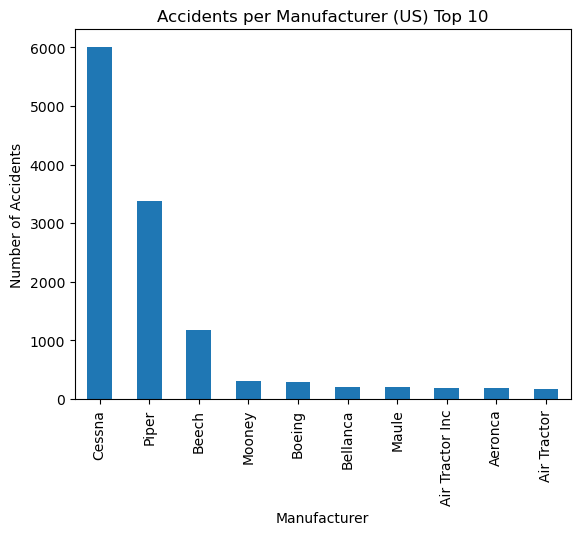

In [88]:
accidents_by_make = clean_aviation_df.groupby('Make')['Event_Date'].count().nlargest(10)

accidents_by_make.plot(kind='bar')
plt.xlabel('Manufacturer')
plt.ylabel('Number of Accidents')
plt.title('Accidents per Manufacturer (US) Top 10')

In [89]:
# accidents per year

accidents_per_year = clean_aviation_df.groupby('Year')['Event_Date'].count()

fatal_accidents_per_year = clean_aviation_df[clean_aviation_df['Injury_Severity'] == 'Fatal'].groupby('Year')['Event_Date'].count()

